## Use a Decision Optimization model deployed in Watson Machine Learning (Local or Cloud Pak for Data)

This notebook shows you how to create and monitor jobs, and get solutions using the Watson Machine Learning Python Client.

In order to use this example, you must first have deployed the Diet example.

A Python API is provided to submit input data, solve, and get results.


In [ ]:
from ibm_watson_machine_learning import APIClient

In [ ]:
cluster = "<your_cluster>"
username = "<username>"
password = "<password>"

wml_credentials = {
    "username": username,
    "password": password,
    "instance_id" : "wml_local",
    "url": cluster,
    "version": "4.8"
}

client = APIClient(wml_credentials)

In [ ]:
# Find the space ID

space_name = "<space_name>"

space_id = [x['metadata']['id'] for x in client.spaces.get_details()['resources'] if x['entity']['name'] == space_name][0]

client.set.default_space(space_id)


In [ ]:
# Import pandas library 
import pandas as pd 
  
# initialize list of lists 
diet_food = pd.DataFrame([ ["Roasted Chicken", 0.84, 0, 10],
                ["Spaghetti W/ Sauce", 0.78, 0, 10],
                ["Tomato,Red,Ripe,Raw", 0.27, 0, 10],
                ["Apple,Raw,W/Skin", 0.24, 0, 10],
                ["Grapes", 0.32, 0, 10],
                ["Chocolate Chip Cookies", 0.03, 0, 10],
                ["Lowfat Milk", 0.23, 0, 10],
                ["Raisin Brn", 0.34, 0, 10],
                ["Hotdog", 0.31, 0, 10]] , columns = ["name","unit_cost","qmin","qmax"])

diet_food_nutrients = pd.DataFrame([
                ["Spaghetti W/ Sauce", 358.2, 80.2, 2.3, 3055.2, 11.6, 58.3, 8.2],
                ["Roasted Chicken", 277.4, 21.9, 1.8, 77.4, 0, 0, 42.2],
                ["Tomato,Red,Ripe,Raw", 25.8, 6.2, 0.6, 766.3, 1.4, 5.7, 1],
                ["Apple,Raw,W/Skin", 81.4, 9.7, 0.2, 73.1, 3.7, 21, 0.3],
                ["Grapes", 15.1, 3.4, 0.1, 24, 0.2, 4.1, 0.2],
                ["Chocolate Chip Cookies", 78.1, 6.2, 0.4, 101.8, 0, 9.3, 0.9],
                ["Lowfat Milk", 121.2, 296.7, 0.1, 500.2, 0, 11.7, 8.1],
                ["Raisin Brn", 115.1, 12.9, 16.8, 1250.2, 4, 27.9, 4],
                ["Hotdog", 242.1, 23.5, 2.3, 0, 0, 18, 10.4 ]
            ] , columns = ["Food","Calories","Calcium","Iron","Vit_A","Dietary_Fiber","Carbohydrates","Protein"])

diet_nutrients = pd.DataFrame([
                ["Calories", 2000, 2500],
                ["Calcium", 800, 1600],
                ["Iron", 10, 30],
                ["Vit_A", 5000, 50000],
                ["Dietary_Fiber", 25, 100],
                ["Carbohydrates", 0, 300],
                ["Protein", 50, 100]
            ], columns = ["name","qmin","qmax"])

You can find the deployment ID in the Analytics deployment spaces. 
Or by listing the deployment using the API.

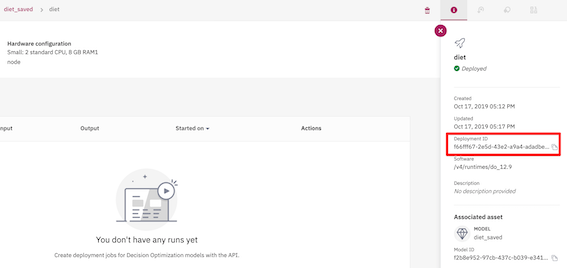


In [ ]:
client.deployments.list()

In [ ]:
# Get the deployment ID from the Model name.
# Note, that there could be several deployments for one model
model_name = "diet"
deployment_uid = [x['metadata']['id'] for x in client.deployments.get_details()['resources'] if x['entity']['name'] == model_name][0]

print(deployment_uid)

Create and monitor a job with inline data for your deployed model. 
Create a payload containing inline input data.

Create a new job with this payload and the deployment.

Get the job_uid.

In [ ]:
solve_payload = {
    client.deployments.DecisionOptimizationMetaNames.INPUT_DATA: [
        {
            "id":"diet_food.csv",
            "values" : diet_food
        },
        {
            "id":"diet_food_nutrients.csv",
            "values" : diet_food_nutrients
        },
        {
            "id":"diet_nutrients.csv",
            "values" : diet_nutrients
        }
    ],
    client.deployments.DecisionOptimizationMetaNames.OUTPUT_DATA: [
        {
            "id":".*\.csv"
        }
    ]
}

job_details = client.deployments.create_job(deployment_uid, solve_payload)
job_uid = client.deployments.get_job_uid(job_details)

print( job_uid )

Display job status until it is completed.

The first job of a new deployment might take some time as a compute node must be started.

In [ ]:
from time import sleep

while job_details['entity']['decision_optimization']['status']['state'] not in ['completed', 'failed', 'canceled']:
    print(job_details['entity']['decision_optimization']['status']['state'] + '...')
    sleep(5)
    job_details=client.deployments.get_job_details(job_uid)

print( job_details['entity']['decision_optimization']['status']['state'])

In [ ]:
job_details['entity']['decision_optimization']['status']

Extract and display solution. 
Display the output solution.

Display the KPI Total Calories value.

In [ ]:
solution_table=[x for x in job_details['entity']['decision_optimization']['output_data'] if x['id'] == 'solution.csv'][0]

# Create a dataframe for the solution
solution = pd.DataFrame(solution_table['values'], 
                        columns = solution_table['fields'])
solution.head()

In [ ]:
print( job_details['entity']['decision_optimization']['solve_state']['details']['KPI.Total Calories'] )

<hr>
Copyright &copy; 2017-2023 IBM. This notebook and its source code are released under the terms of the MIT License.